<a href="https://colab.research.google.com/github/SinhaPrateek/Chicago_taxi_trips/blob/main/Chicago_Taxi_Trips_Problem_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


##Importing Libraries

In [ ]:
import time 
%matplotlib inline
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Loading Data from BigQuery Public Dataset

In [ ]:

start = time.time()
project_id = ''

from google.cloud import bigquery

client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT
  *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp < TIMESTAMP('2017-01-01 00:00:00')
AND trip_end_timestamp < TIMESTAMP('2017-01-01 00:00:00')
AND trip_seconds>0
LIMIT 100000
''').to_dataframe()

end = time.time()
print("time taken(s) to run query is : %d" %(end-start))

time taken(s) to run query is : 28


In [ ]:
train.shape

(100000, 23)

In [ ]:
start = time.time()
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

test = client.query('''
  SELECT
  *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_start_timestamp >= TIMESTAMP('2017-01-01 00:00:00')
AND trip_end_timestamp >= TIMESTAMP('2017-01-01 00:00:00')
AND trip_seconds>0
LIMIT 20000
''').to_dataframe()

end = time.time()
print("time taken(s) to run query is : %d" %(end-start))

time taken(s) to run query is : 6


##Data understanding

In [ ]:
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('We need to worry about missing values.')

We need to worry about missing values.


In [ ]:
print('unique_key is unique.') if train.unique_key.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.unique_key.values, test.unique_key.values))== 0 else print('oops')

unique_key is unique.
Train and test sets are distinct.


Dropping rows with null values for specified columns

In [ ]:
train.dropna(subset=['trip_seconds','trip_miles','pickup_latitude','pickup_longitude','pickup_location','dropoff_latitude','dropoff_longitude','dropoff_location'],inplace = True)
test.dropna(subset=['trip_seconds','trip_miles','pickup_latitude','pickup_longitude','pickup_location','dropoff_latitude','dropoff_longitude','dropoff_location'],inplace = True)


In [ ]:
train.unique_key.nunique()

97426

In [ ]:
train.shape

(97426, 23)

In [ ]:
train['trip_start_timestamp'] = pd.to_datetime(train.trip_start_timestamp)
test['trip_start_timestamp'] = pd.to_datetime(test.trip_start_timestamp)
train.loc[:, 'pickup_date'] = train['trip_start_timestamp'].dt.date
test.loc[:, 'pickup_date'] = test['trip_start_timestamp'].dt.date
train['trip_end_timestamp'] = pd.to_datetime(train.trip_end_timestamp)
train['check_trip_seconds'] = (train['trip_end_timestamp'] - train['trip_start_timestamp']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_seconds'].values  - train['trip_seconds'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'check_trip_seconds']]) == 0 else print('Ooops.')

Ooops.


Difference between pickup and drop time is not equal to trip_seconds. This  can be because of rounding to 15 min, so we will only use 'trip_seconds' column

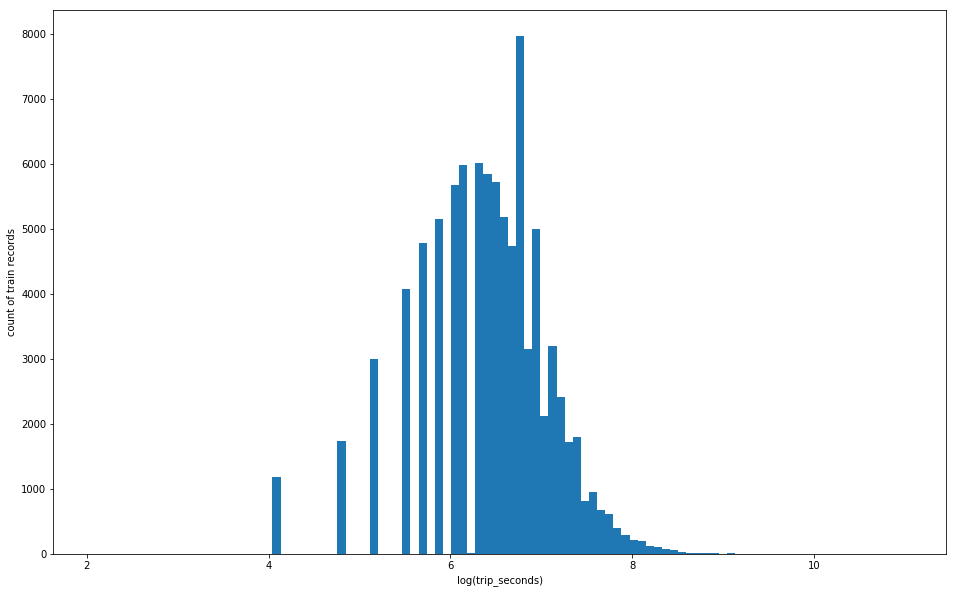

In [ ]:
train['log_trip_seconds'] = np.log(train['trip_seconds'].values + 1)
plt.hist(train['log_trip_seconds'].values, bins=100)
plt.xlabel("log(trip_seconds)")
plt.ylabel("count of train records")
plt.show()

In [ ]:
print("Most of the records are around {} min and {} min".format(np.exp(4)/60,np.exp(8)/60))

Most of the records are around 0.9099691672190706 min and 49.68263311736214 min


##Feature Extraction

###Datetime features

In [ ]:
train.loc[:, 'pickup_weekday'] = train['trip_start_timestamp'].dt.weekday  # Monday is 0 and Sunday is 6
train.loc[:, 'pickup_hour_weekofyear'] = train['trip_start_timestamp'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['trip_start_timestamp'].dt.hour
train.loc[:, 'pickup_minute'] = train['trip_start_timestamp'].dt.minute
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['trip_start_timestamp'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['trip_start_timestamp'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['trip_start_timestamp'].dt.hour
test.loc[:, 'pickup_minute'] = test['trip_start_timestamp'].dt.minute
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

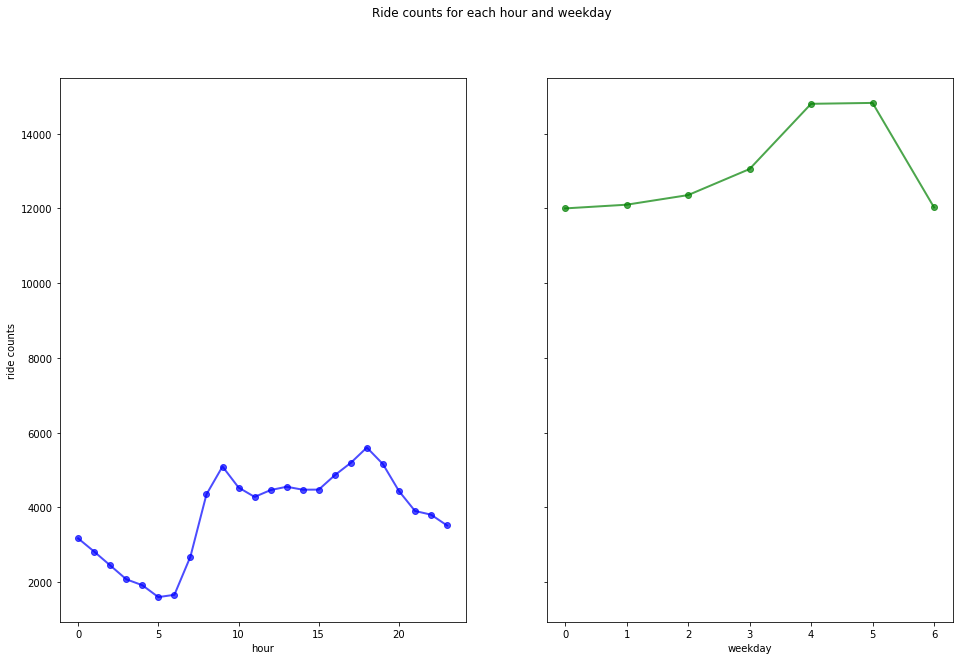

In [ ]:

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').count()['unique_key'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').count()['unique_key'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('ride counts')
fig.suptitle('Ride counts for each hour and weekday')
plt.show()

From above plot, we can see ride counts are min at 5 AM and max at 6 PM(18:00). This is quite as expected.

Average Speed

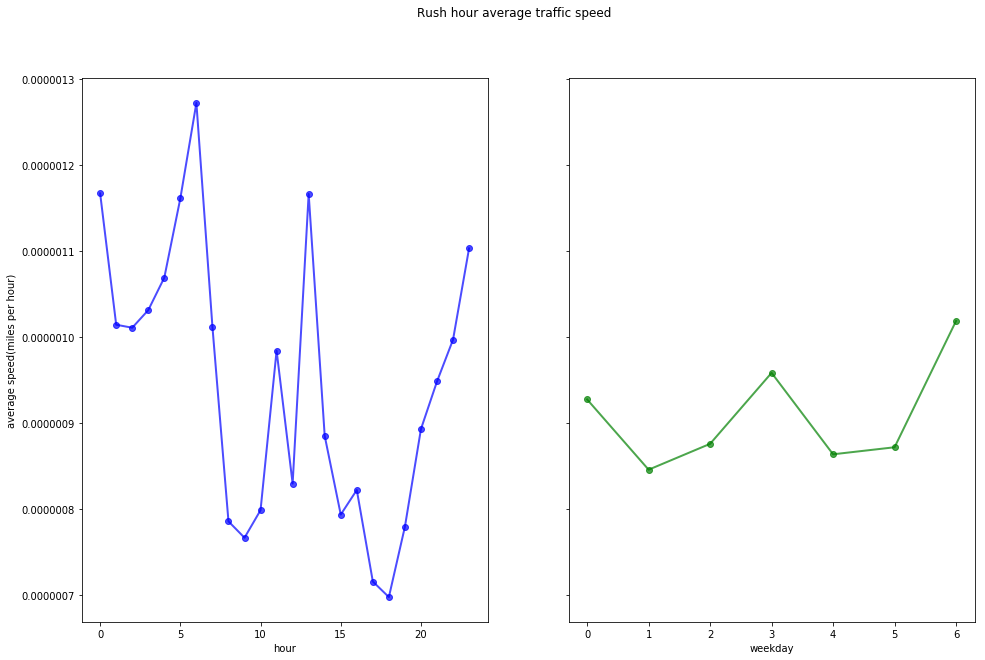

In [ ]:

train.loc[:, 'avg_speed_h'] = train['trip_miles'] / train['trip_seconds']/(60*60)

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
# ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
# ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed(miles per hour)')
fig.suptitle('Rush hour average traffic speed')
plt.show()

As expected, average speed is max during hrs with least rides and vice versa

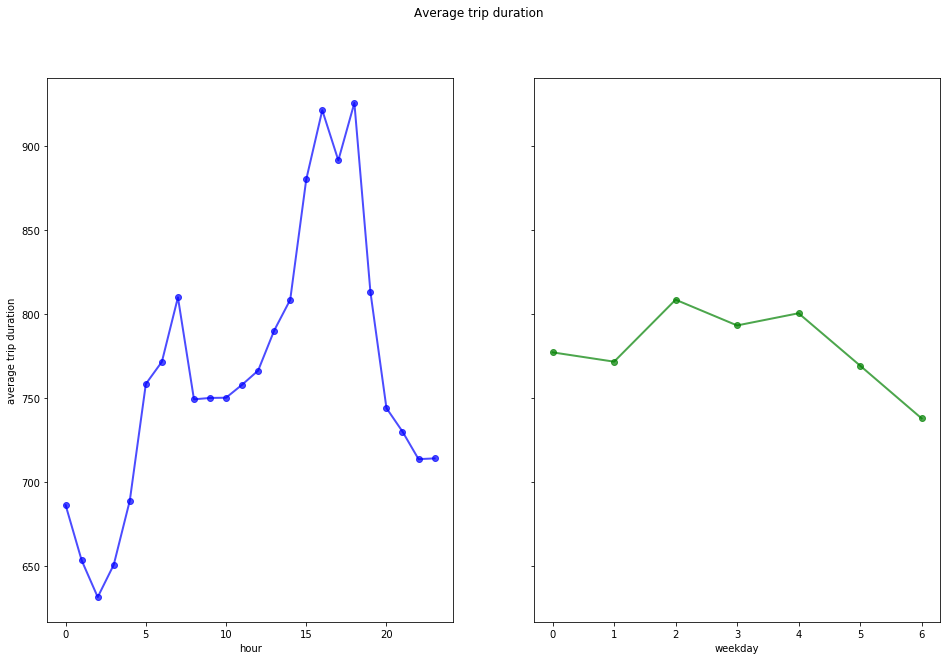

In [ ]:

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['trip_seconds'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['trip_seconds'], 'go-', lw=2, alpha=0.7)
# ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
# ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average trip duration')
fig.suptitle('Average trip duration')
plt.show()

Obviously trip durations should follow the opposite trend to average speed, the above plot confirms that hypothesis

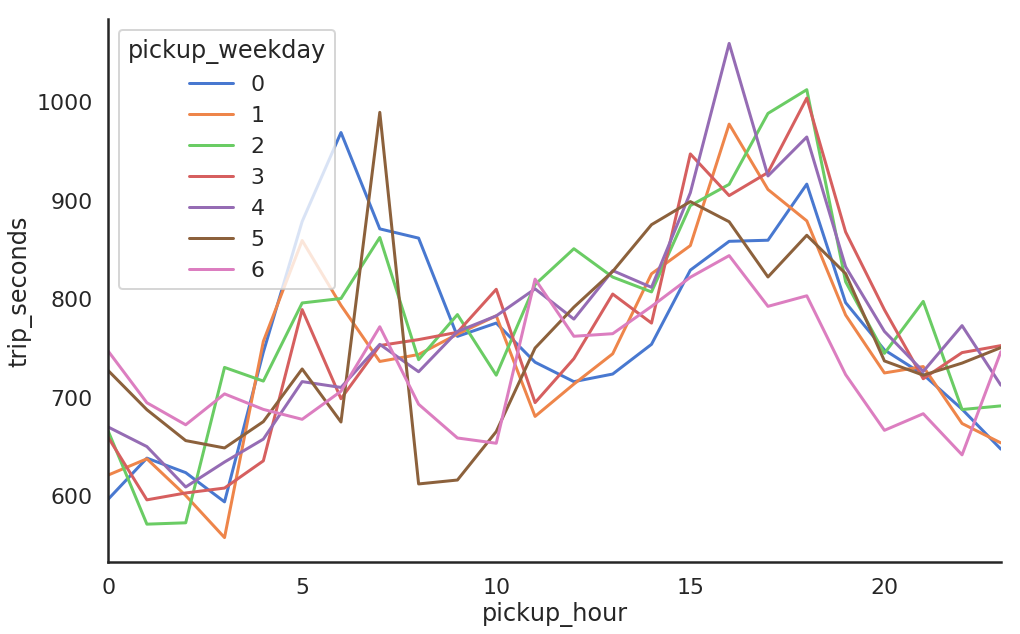

In [ ]:

summary_hour_duration = pd.DataFrame(train.groupby(['pickup_weekday','pickup_hour'])['trip_seconds'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="pickup_weekday", value="trip_seconds")
sns.despine(bottom = False)

It shows that trip durations at any hour follow the trend everyday with max. duration between 15 to 20 hours.

**Conclusion** 

Based on above plots, we should consider featues like hour, weekday, weekhour for training as trip duration depends on them

###Using PCA 

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

###Centre points of pickup and drop 
This helps model to learn the area of city where trip happended

In [ ]:
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

###Using Clustering on latitude and longitude

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85622 entries, 4598 to 99999
Data columns (total 40 columns):
unique_key                85622 non-null object
taxi_id                   85622 non-null object
trip_start_timestamp      85622 non-null datetime64[ns, UTC]
trip_end_timestamp        85622 non-null datetime64[ns, UTC]
trip_seconds              85622 non-null int64
trip_miles                85622 non-null float64
pickup_census_tract       43182 non-null object
dropoff_census_tract      43182 non-null object
pickup_community_area     85622 non-null float64
dropoff_community_area    85622 non-null float64
fare                      85622 non-null float64
tips                      85622 non-null float64
tolls                     85622 non-null float64
extras                    85622 non-null float64
trip_total                85622 non-null float64
payment_type              85622 non-null object
company                   57097 non-null object
pickup_latitude           85622 non-nul

##Modelling

###Approach 1

Creating list of features to be used for training

In [ ]:
feature_names = list(train.columns)
print("Columns missing in test data are: {}".format(np.setdiff1d(train.columns, test.columns)))
do_not_use_for_training = ['unique_key','taxi_id', 'log_trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp',
                           'trip_seconds', 'check_trip_seconds', 'pickup_census_tract',
                           'dropoff_census_tract', 'pickup_community_area',
                           'dropoff_community_area', 'tips', 'extras',
                           'payment_type', 'company','fare','tolls',
                           'pickup_location', 'dropoff_location', 'pickup_date',
                           'check_trip_seconds', 'log_trip_seconds',
                           'avg_speed_h','pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1','pickup_cluster', 'dropoff_cluster']

feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("columns used for modelling are: {}".format(feature_names))
print('We have %i features.' % len(feature_names))

train[feature_names].count()
y = np.log(train['trip_seconds'].values + 1)

Columns missing in test data are: ['avg_speed_h' 'check_trip_seconds' 'log_trip_seconds']
columns used for modelling are: ['trip_miles', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'center_latitude', 'center_longitude']
We have 13 features.


Using cross validation to check the performance of various models

In [ ]:
import sklearn.metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
 
x = train[feature_names].values

k = 10
seed = 7
scoring = 'neg_mean_absolute_error'

cv = KFold(n_splits = k, random_state = seed)
models = []
results =[]
modelNames = []

models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('LA', Lasso()))
models.append(('R',Ridge()))


for name,model in models:
    kfold = KFold(n_splits = k, random_state = seed)
    cv_results = cross_val_score(model,x, y, cv=kfold, scoring = scoring)
    results.append(cv_results)
    modelNames.append(name)
    msg = "%s : %s, %s" %(name,cv_results.mean(),cv_results.std())
    print(msg)

LR : -0.4810390631564812, 0.08718357312589818
DT : -0.31551064765530445, 0.021916339178881306
LA : -0.5240290791836049, 0.0957525699553817
R : -0.4808212797307891, 0.08672763302405861


In [ ]:
train[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91138 entries, 3492 to 99999
Data columns (total 13 columns):
trip_miles                91138 non-null float64
trip_total                91138 non-null float64
pickup_latitude           91138 non-null float64
pickup_longitude          91138 non-null float64
dropoff_latitude          91138 non-null float64
dropoff_longitude         91138 non-null float64
pickup_weekday            91138 non-null int64
pickup_hour_weekofyear    91138 non-null int64
pickup_hour               91138 non-null int64
pickup_minute             91138 non-null int64
pickup_week_hour          91138 non-null int64
center_latitude           91138 non-null float64
center_longitude          91138 non-null float64
dtypes: float64(8), int64(5)
memory usage: 9.7 MB


XGBoost 

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values, label = test[['trip_seconds']].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid'), (dtest, 'eval')]

# parameters, mostly default
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 1, 'max_depth': 6,
            'subsample': 1, 'lambda': 1., 'booster' : 'gbtree', 'silent': 1,
            'eval_metric':['mae','rmse'], 'objective': 'reg:linear'}

In [ ]:
model = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-mae:4.14909	train-rmse:4.1845	valid-mae:4.14516	valid-rmse:4.18117	eval-mae:728.383	eval-rmse:1166.52
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[10]	train-mae:0.238545	train-rmse:0.32347	valid-mae:0.242966	valid-rmse:0.327254	eval-mae:724.361	eval-rmse:1163.83
[20]	train-mae:0.202363	train-rmse:0.288022	valid-mae:0.209657	valid-rmse:0.299248	eval-mae:724.252	eval-rmse:1163.75
[30]	train-mae:0.197716	train-rmse:0.280132	valid-mae:0.207439	valid-rmse:0.297179	eval-mae:724.253	eval-rmse:1163.75
[40]	train-mae:0.193714	train-rmse:0.274056	valid-mae:0.205885	valid-rmse:0.296524	eval-mae:724.259	eval-rmse:1163.75
[50]	train-mae:0.190957	train-rmse:0.26985	valid-mae:0.205087	valid-rmse:0.295991	eval-mae:724.265	eval-rmse:1163.75
[60]	train-mae:0.189185	train-rmse:0.267301	valid-mae:0.204766	valid-rmse:0.295737	eval-mae:724.27	eval-rmse:1163.75
[70]	train-mae:0.187172	train-rmse:0.264

XGBoost val error is least compared to other models, so let us use that to make further improvement

Prediction

In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_seconds_pred'] = np.exp(ytest) - 1

Test shape OK.


In [ ]:
test.head(5)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,pickup_date,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_week_hour,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,center_latitude,center_longitude,pickup_cluster,dropoff_cluster,trip_seconds_pred
127,3d480ae509c5f4899ee510cd84ac2800e9d9ad8b,1f7013cdde4f526253df066ec65f39c6c5d8b20782091c...,2017-04-30 22:45:00+00:00,2017-04-30 22:45:00+00:00,180,0.7,NaN,NaN,14.0,14.0,4.75,0.00,0.0,0.0,4.75,Cash,Northwest Management LLC,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2017-04-30,6,17,22,45,166,0.10033,0.006392,0.10033,0.006392,41.968069,-87.721559,6,6,192.955109
128,3d4cf9eda4a063bdb5f487ed060c45b79154f388,845cdbcd961992102ca6b9de75a863d83d457881dad5bf...,2017-02-06 11:15:00+00:00,2017-02-06 11:15:00+00:00,60,0.0,NaN,NaN,14.0,14.0,3.25,0.00,0.0,0.0,3.25,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2017-02-06,0,6,11,15,11,0.10033,0.006392,0.10033,0.006392,41.968069,-87.721559,6,6,60.169571
129,3d6d97690b4207c9d8148ec15490f3c7362cd337,7b3a4ffae6221ac1f4a49cafa742d4c7795b721e442c3e...,2017-02-16 22:30:00+00:00,2017-02-16 22:30:00+00:00,660,0.0,NaN,NaN,14.0,14.0,8.00,0.00,0.0,0.0,8.00,Cash,Blue Ribbon Taxi Association Inc.,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2017-02-16,3,7,22,30,94,0.10033,0.006392,0.10033,0.006392,41.968069,-87.721559,6,6,376.014587
130,3d87047c74421604f4b4ce23addc87f996cec0e2,6283d7e0bc1bb306ec117871d27b644413fb91fe9e8129...,2017-04-15 05:15:00+00:00,2017-04-15 05:15:00+00:00,120,0.8,NaN,NaN,14.0,14.0,5.00,2.08,0.0,0.0,7.08,Credit Card,Dispatch Taxi Affiliation,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2017-04-15,5,15,5,15,125,0.10033,0.006392,0.10033,0.006392,41.968069,-87.721559,6,6,240.936569
131,3da3a1f29de529a980cc2eb1b4e2fb841dfb6c50,edecbf70f406121a7ba41112ad929b6e569e0bdc06ee50...,2017-01-26 16:15:00+00:00,2017-01-26 16:15:00+00:00,1,0.0,NaN,NaN,14.0,14.0,3.25,0.00,0.0,3.0,6.25,Cash,None,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2017-01-26,3,4,16,15,88,0.10033,0.006392,0.10033,0.006392,41.968069,-87.721559,6,6,322.602600


In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test['trip_seconds'].values, test['trip_seconds_pred'].values)

185.34649086637694

####test MAPE 

In [ ]:
np.mean(np.abs((test['trip_seconds'].values - test['trip_seconds_pred'].values)/(test['trip_seconds'].values)))*100

37.84936026991198

In [ ]:
import math
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5
	
	
	
rmsle(test['trip_seconds'].values, test['trip_seconds_pred'].values)

0.36872514650171523

###Approach 2 : Adding features from PCA

In [ ]:
feature_names = list(train.columns)
print("Columns missing in test data are: {}".format(np.setdiff1d(train.columns, test.columns)))
do_not_use_for_training = ['unique_key','taxi_id', 'log_trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp',
                           'trip_seconds', 'check_trip_seconds', 'pickup_census_tract',
                           'dropoff_census_tract', 'pickup_community_area',
                           'dropoff_community_area', 'tips', 'extras',
                           'payment_type', 'company','fare','tolls',
                           'pickup_location', 'dropoff_location', 'pickup_date',
                           'check_trip_seconds', 'log_trip_seconds',
                           'avg_speed_h','pickup_cluster', 'dropoff_cluster']


feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("columns used for modelling are: {}".format(feature_names))
print('We have %i features.' % len(feature_names))

train[feature_names].count()
y = np.log(train['trip_seconds'].values + 1)

Columns missing in test data are: ['avg_speed_h' 'check_trip_seconds' 'log_trip_seconds']
columns used for modelling are: ['trip_miles', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'center_latitude', 'center_longitude']
We have 17 features.


In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# parameters, mostly default
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 1, 'max_depth': 6,
            'subsample': 1, 'lambda': 1., 'booster' : 'gbtree', 'silent': 1,
            'eval_metric':['mae','rmse'], 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist,early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-mae:4.1491	train-rmse:4.1845	valid-mae:4.14515	valid-rmse:4.18116
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-mae:0.23799	train-rmse:0.323245	valid-mae:0.242552	valid-rmse:0.326949
[20]	train-mae:0.202278	train-rmse:0.288257	valid-mae:0.209798	valid-rmse:0.300328
[30]	train-mae:0.197357	train-rmse:0.280362	valid-mae:0.207129	valid-rmse:0.29737
[40]	train-mae:0.193505	train-rmse:0.273949	valid-mae:0.205292	valid-rmse:0.295814
[50]	train-mae:0.190772	train-rmse:0.269635	valid-mae:0.20438	valid-rmse:0.295205
[59]	train-mae:0.18877	train-rmse:0.26595	valid-mae:0.20377	valid-rmse:0.294876


####test MAPE 

In [ ]:
np.mean(np.abs((test['trip_seconds'].values - test['trip_seconds_pred'].values)/(test['trip_seconds'].values)))*100

37.84936026991198

###Approach 3 : Adding Features from Clustering

Creating list of features to be used for training

In [ ]:
feature_names = list(train.columns)
print("Columns missing in test data are: {}".format(np.setdiff1d(train.columns, test.columns)))
do_not_use_for_training = ['unique_key','taxi_id', 'log_trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp',
                           'trip_seconds', 'check_trip_seconds', 'pickup_census_tract',
                           'dropoff_census_tract', 'pickup_community_area',
                           'dropoff_community_area', 'tips', 'extras',
                           'payment_type', 'company','fare','tolls',
                           'pickup_location', 'dropoff_location', 'pickup_date',
                           'check_trip_seconds', 'log_trip_seconds',
                           'avg_speed_h']


feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("columns used for modelling are: {}".format(feature_names))
print('We have %i features.' % len(feature_names))

train[feature_names].count()
y = np.log(train['trip_seconds'].values + 1)

Columns missing in test data are: ['avg_speed_h' 'check_trip_seconds' 'log_trip_seconds']
columns used for modelling are: ['trip_miles', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'center_latitude', 'center_longitude', 'pickup_cluster', 'dropoff_cluster']
We have 19 features.


In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# parameters, mostly default
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 1, 'max_depth': 6,
            'subsample': 1, 'lambda': 1., 'booster' : 'gbtree', 'silent': 1,
            'eval_metric':['mae','rmse'], 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist,early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-mae:4.1491	train-rmse:4.1845	valid-mae:4.14515	valid-rmse:4.18116
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-mae:0.237794	train-rmse:0.322783	valid-mae:0.242289	valid-rmse:0.327434
[20]	train-mae:0.201906	train-rmse:0.286912	valid-mae:0.209428	valid-rmse:0.299117
[30]	train-mae:0.196923	train-rmse:0.27925	valid-mae:0.206655	valid-rmse:0.296657
[40]	train-mae:0.19397	train-rmse:0.274217	valid-mae:0.205628	valid-rmse:0.295675
[50]	train-mae:0.191133	train-rmse:0.269935	valid-mae:0.204631	valid-rmse:0.294945
[59]	train-mae:0.189315	train-rmse:0.26704	valid-mae:0.204294	valid-rmse:0.294717


Prediction

In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_seconds_pred'] = np.exp(ytest) - 1

Test shape OK.


####test MAPE 

In [ ]:
np.mean(np.abs((test['trip_seconds'].values - test['trip_seconds_pred'].values)/(test['trip_seconds'].values)))*100

38.32525382249353

###Approach 4 : Removing Outliers

Removing outliers from train and test data for few features

In [ ]:
from scipy import stats
feature_remove_outliers = ['trip_seconds','trip_miles', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

train = train[(np.abs(stats.zscore(train[feature_remove_outliers].values)) < 3).all(axis=1)]

test = test[(np.abs(stats.zscore(test[feature_remove_outliers].values)) < 3).all(axis=1)]


Creating list of features to be used for training

In [ ]:
feature_names = list(train.columns)
print("Columns missing in test data are: {}".format(np.setdiff1d(train.columns, test.columns)))
do_not_use_for_training = ['unique_key','taxi_id', 'log_trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp',
                           'trip_seconds', 'check_trip_seconds', 'pickup_census_tract',
                           'dropoff_census_tract', 'pickup_community_area',
                           'dropoff_community_area', 'tips', 'extras',
                           'payment_type', 'company','fare','tolls',
                           'pickup_location', 'dropoff_location', 'pickup_date',
                           'check_trip_seconds', 'log_trip_seconds',
                           'avg_speed_h']


feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("columns used for modelling are: {}".format(feature_names))
print('We have %i features.' % len(feature_names))

train[feature_names].count()
y = np.log(train['trip_seconds'].values + 1)

Columns missing in test data are: ['avg_speed_h' 'check_trip_seconds' 'log_trip_seconds']
columns used for modelling are: ['trip_miles', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'center_latitude', 'center_longitude', 'pickup_cluster', 'dropoff_cluster']
We have 19 features.


In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# parameters, mostly default
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 1, 'max_depth': 6,
            'subsample': 1, 'lambda': 1., 'booster' : 'gbtree', 'silent': 1,
            'eval_metric':['mae','rmse'], 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist,early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-mae:4.12015	train-rmse:4.15182	valid-mae:4.12126	valid-rmse:4.15305
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-mae:0.234908	train-rmse:0.305099	valid-mae:0.237104	valid-rmse:0.306022
[20]	train-mae:0.198214	train-rmse:0.2696	valid-mae:0.203056	valid-rmse:0.276186
[30]	train-mae:0.193965	train-rmse:0.264027	valid-mae:0.201095	valid-rmse:0.275129
[40]	train-mae:0.190936	train-rmse:0.259605	valid-mae:0.199921	valid-rmse:0.274331
[50]	train-mae:0.188185	train-rmse:0.255868	valid-mae:0.198765	valid-rmse:0.27356
[59]	train-mae:0.185552	train-rmse:0.252349	valid-mae:0.197916	valid-rmse:0.272944


Prediction

In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_seconds_pred'] = np.exp(ytest) - 1

Test shape OK.


####test MAPE 

In [ ]:
np.mean(np.abs((test['trip_seconds'].values - test['trip_seconds_pred'].values)/(test['trip_seconds'].values)))*100

32.832280739967494

###Approach 5 : Adding features fare, tolls, centre_latitude, centre_longitude
### Outliers removed

Creating list of features to be used for training

In [ ]:
feature_names = list(train.columns)
print("Columns missing in test data are: {}".format(np.setdiff1d(train.columns, test.columns)))
do_not_use_for_training = ['unique_key','taxi_id', 'log_trip_seconds', 'trip_start_timestamp', 'trip_end_timestamp',
                           'trip_seconds', 'check_trip_seconds', 'pickup_census_tract',
                           'dropoff_census_tract', 'pickup_community_area',
                           'dropoff_community_area', 'tips', 'extras',
                           'payment_type', 'company',
                           'pickup_location', 'dropoff_location', 'pickup_date',
                           'check_trip_seconds', 'log_trip_seconds',
                           'avg_speed_h']


feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("columns used for modelling are: {}".format(feature_names))
print('We have %i features.' % len(feature_names))

train[feature_names].count()
y = np.log(train['trip_seconds'].values + 1)

Columns missing in test data are: ['avg_speed_h' 'check_trip_seconds' 'log_trip_seconds']
columns used for modelling are: ['trip_miles', 'fare', 'tolls', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'center_latitude', 'center_longitude', 'pickup_cluster', 'dropoff_cluster']
We have 21 features.


In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# parameters, mostly default
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 1, 'max_depth': 6,
            'subsample': 1, 'lambda': 1., 'booster' : 'gbtree', 'silent': 1,
            'eval_metric':['mae','rmse'], 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist,early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-mae:4.12015	train-rmse:4.14922	valid-mae:4.1218	valid-rmse:4.15106
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-mae:0.182766	train-rmse:0.235408	valid-mae:0.184608	valid-rmse:0.236454
[20]	train-mae:0.136243	train-rmse:0.190229	valid-mae:0.139825	valid-rmse:0.197363
[30]	train-mae:0.131423	train-rmse:0.183216	valid-mae:0.136607	valid-rmse:0.19419
[40]	train-mae:0.12844	train-rmse:0.178469	valid-mae:0.134997	valid-rmse:0.192967
[50]	train-mae:0.125759	train-rmse:0.174725	valid-mae:0.133328	valid-rmse:0.191853
[59]	train-mae:0.123409	train-rmse:0.171271	valid-mae:0.132127	valid-rmse:0.190841


Prediction

In [ ]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['trip_seconds_pred'] = np.exp(ytest) - 1

Test shape OK.


####test MAPE 

In [ ]:
np.mean(np.abs((test['trip_seconds'].values - test['trip_seconds_pred'].values)/(test['trip_seconds'].values)))*100

22.43962691160326

##Conclusion

Best test MAPE (Mean Absolute Percentage Error) achieved is 20.66.

columns used for this model are: ['trip_miles', 'fare', 'tolls', 'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'pickup_cluster', 'dropoff_cluster', 'center_latitude', 'center_longitude']

Using features like tolls, fare, centre_latitude, centre_longitude and outliers removed, improvement in test MAPE was from 33.42 to 20.66

##Improvement Areas
I have used default parameters for XGBoost.
So, model can be improved by selecting best parameters using random search (taking different combination of parameters and checking which combination reduces MAPE the most)

Since, test data only cotains records upto July of 2017, we can try to take trsining data also only till July